# Neural Network

In [346]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [350]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'orange', 'cyan'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 200
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=5, c=colors[i])

In [ ]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class CNNLayer(MLPLayer, metaclass=ABCMeta):
    def im2col(self, img, FH, FW, stride, pad):
        N, C, H, W = img.shape
        #FN, C, FH, FW = filters.shape
        # フィルタ適用後のimageサイズ
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        img_padded = np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, FH, FW, OH, OW))
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                col[:, :, y, x, :, :] = img_padded[:, :, y:ymax:stride, x:xmax:stride]
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW, -1)
        return col
    
    def col2im(self, col, img_shape, FH, FW, stride, pad):
        N, C, H, W = img_shape
        #FN, C, FH, FW = filters.shape
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        
        col_reshaped = col.reshape(N, OH, OW, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                img[:, :, y:ymax:stride, x:xmax:stride] += col_reshaped[:, :, y, x, :, :]
        img = img[:, :, pad:pad+H, pad:pad+W]
        return img





class Affine(MLPLayer):
    def __init__(self, W, b):
        # モデルの重み
        self.W = W
        self.b = b
        # 重みの勾配
        self.dW = None
        self.db = None
        # 誤差逆伝播用の中間データ
        self.A = None

    def forward(self, A, is_training=False):
        out = np.dot(A, self.W.T) + self.b
        
        if is_training:
            self.A = A
        return out

    def backward(self, dout):
        dA = np.dot(dout, self.W)
        self.dW = np.dot(dout.T, self.A)
        self.db = dout.sum(axis=0)
        
        self.A = None
        return dA


class Sigmoid(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.sigmoid = None
    
    def forward(self, Z, is_training=False):
        sigmoid = 1.0 / (1.0 + np.exp(-Z))
        
        if is_training:
            self.sigmoid = sigmoid
        return sigmoid
    
    def backward(self, dout):
        dphi = self.sigmoid * (1.0 - self.sigmoid)
        dZ = dout * dphi
        
        self.sigmoid = None
        return dZ


class HyperbolicTangent(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Z = None
    
    def forward(self, Z, is_training=False):
        out = np.tanh(Z)
        
        if is_training:
            self.Z = Z.copy()
        return out
    
    def backward(self, dout):
        dphi = 1.0 / np.cosh(self.Z)**2
        dZ = dout * dphi
        
        self.Z = None
        return dZ


class ReLU(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.mask = None
    
    def forward(self, Z, is_training=False):
        mask = Z <= 0
        out = Z.copy()
        out[mask] = 0
        
        if is_training:
            self.mask = mask
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        
        self.mask = None
        return dZ


class SoftMax(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y = None
    
    def forward(self, Z, is_training=False):
        Z_exp = np.exp(Z)
        Y = (Z_exp.T / Z_exp.sum(axis=1)).T
        
        if is_training:
            self.Y = Y
        return Y
    
    def backward(self, dout):
        dZ = self.Y * (dout.T - np.sum(self.Y * dout, axis=1)).T
        
        self.Y = None
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct, is_training=False):
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=1)
        cost = np.average(cost)
        
        if is_training:
            self.Y_predict = Y_predict
            self.Y_correct = Y_correct
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[0]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        
        self.Y_predict = None
        self.Y_correct = None
        return dA


class BatchNormalization(MLPLayer):
    def __init__(self, n_units, eps=1e-8):
        self.eps = eps
        # モデルの重み
        self.gamma = np.full(n_units, 1.0)
        self.beta = np.zeros(n_units)
        # 重みの勾配
        self.dgamma = None
        self.dbeta = None
        # 誤差逆伝播用の中間データ
        self.std = None
        self.Z_norm = None
    
    def forward(self, Z, is_training=False):
        shape = Z.shape
        Z = Z.reshape(shape[0], -1)
        
        mu = np.average(Z, axis=0)
        std = np.std(Z, axis=0)
        Z_norm = (Z - mu) / np.sqrt(std**2 + self.eps)
        out = self.gamma * Z_norm + self.beta
        
        if is_training:
            self.std = std
            self.Z_norm = Z_norm
        out = out.reshape(shape)
        return out
    
    def backward(self, dout):
        shape = dout.shape
        dout = dout.reshape(shape[0], -1)
        
        n_batch = shape[0]
        self.dgamma = (dout * self.Z_norm).sum(axis=0)
        self.dbeta = dout.sum(axis=0)
        dZ = self.gamma / (n_batch * np.sqrt(self.std**2 + self.eps)) * (
            n_batch * dout - self.dbeta - self.Z_norm * self.dgamma
        )
        dZ = dZ.reshape(shape)
        
        self.std = None
        self.Z_norm = None
        return dZ


class Convolution(CNNLayer):
    """
    Attributes
    ----------
    filters : numpy array (FN, C, FH, FW)
        FN : 出力チャンネル数
        C  : 入力チャンネル数
        FH : フィルタの行数
        FW : フィルタの列数
    bias : numpy array
    stride : 
    pad : 
    """
    def __init__(self, filters, bias, stride=1, pad=0):
        self.filters = filters
        self.bias = bias
        self.stride = stride
        self.pad = pad
        self.dF = None
        self.db = None
        self.img = None
        self.col_img = None
        self.col_filters = None
    
    def forward(self, img, is_training=False):
        FN, C, FH, FW = self.filters.shape
        N, C, H, W = img.shape
        #H, W = H + self.pad * 2, W + self.pad * 2
        
        col_img = self.im2col(img, FH, FW, stride=self.stride, pad=self.pad).T
        col_filters = self.filters.reshape(FN, -1)
        
        OH = (H + self.pad * 2 - FH) // self.stride + 1
        OW = (W + self.pad * 2 - FW) // self.stride + 1
        
        if (OH - 1) * self.stride - self.pad * 2 + FH != H or (OW - 1) * self.stride - self.pad * 2 + FW != W:
            raise Exception('ストライド幅が不適')
        
        if is_training:
            self.img = img
            self.col_img = col_img
            self.col_filters = col_filters
        
        out = (np.dot(col_filters, col_img).T + self.bias).T
        out = out.reshape(FN, N, OH, OW).transpose(1, 0, 2, 3)
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.filters.shape
        #N, C, H, W = dout.shape
        
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, FN) # N, H, W, C
        self.db = dout_reshaped.sum(axis=0)
        self.dF = np.dot(self.col_img, dout_reshaped).T.reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout_reshaped, self.col_filters)
        dimg = self.col2im(dcol, self.img.shape, FH, FW, self.stride, self.pad)
        
        self.img = None
        self.col_img = None
        self.col_filters = None
        
        return dimg


class MaxPooling(CNNLayer):
    """
    def __init__(self, PH, PW, stride=1, pad=0):
        self.pool_h = PH
        self.pool_w = PW
        self.stride = stride
        self.pad = pad
        self.img = None
        self.max_args = None
    
    def forward(self, x, is_training=False):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
    """
    def __init__(self, PH, PW, stride=1, pad=0):
        self.PH = PH
        self.PW = PW
        self.stride = stride
        self.pad = pad
        self.img = None
        self.max_args = None
    
    def forward(self, img, is_training=False):
        N, C, H, W = img.shape
        OH = (H + self.pad * 2 - self.PH) // self.stride + 1
        OW = (W + self.pad * 2 - self.PW) // self.stride + 1
        
        col_img = self.im2col(img, self.PH, self.PW, self.stride, self.pad).reshape(-1, self.PH*self.PW)
        max_args = col_img.argmax(axis=1)
        out = col_img.max(axis=1).reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
        
        if is_training:
            self.img = img
            self.max_args = max_args
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)  # N, H, W, C
        
        pool_size = self.PH * self.PW
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.max_args.size), self.max_args.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dimg = self.col2im(dcol, self.img.shape, self.PH, self.PW, self.stride, self.pad)
        
        self.img = None
        self.max_args = None
        
        return dimg


class Flatten(MLPLayer):
    def __init__(self):
        self.img_shape = None
    
    def forward(self, img, is_training=False):
        """
        (N, C, H, W) -> (N, C*H*W)
        """
        img_shape = img.shape
        out = img.reshape(img_shape[0], -1)
        
        if is_training:
            self.img_shape = img_shape
        
        return out
    
    def backward(self, dout):
        """
        (N, C*H*W) -> (N, C, H, W)
        """
        dimg = dout.reshape(self.img_shape)
        self.img_shape = None
        return dimg


class Dropout(MLPLayer):
    def __init__(self, ratio=0.5):
        self.ratio = ratio
        self.mask = None
    
    def forward(self, x, is_training=False):
        if is_training:
            self.mask = np.random.rand(*x.shape) > self.ratio
            return x * self.mask
        else:
            return x * (1.0 - self.ratio)
    
    def backward(self, dout):
        dx = dout * self.mask
        self.mask = None
        return dx



import copy
import numpy as np
from datetime import datetime

class SimpleMLPClassifier:
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=0.,
                 hidden_activation_class=ReLU, debug_grad_check=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.hidden_activation_class = hidden_activation_class
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def predict(self, data):
        out = data.copy()
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=1)
        return self.index2label[i_label]
    
    def fit(self, data_train, labels_train, data_test, labels_test):
        if self.layers is None:
            self.index2label = np.unique(labels_train)
            self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        
        N_train = len(data_train)
        N_test = len(data_test)
        L = len(np.unique(labels_train))
        
        X_train = data_train.copy()
        Y_train = np.zeros([N_train, L])
        for i in range(N_train):
            l = labels_train[i]
            Y_train[i][self.label2index[l]] = 1.0
        X_test = data_test.copy()
        Y_test = np.zeros([N_test, L])
        for i in range(N_test):
            l = labels_test[i]
            Y_test[i][self.label2index[l]] = 1.0
        
        if self.layers is None:
            self.initialize_layers(X_train, Y_train)
            self.cost_train = []
            self.cost_test = []
            self.acc_train = []
            self.acc_test = []
            self.grad_err = []
            self.__evaluate(X_train, Y_train, X_test, Y_test)
        
        display_progress = max(self.epochs // 10, 1)
        for epoch in range(1, self.epochs+1):
            for _ in range(N_train // self.n_batch):
                # ミニバッチデータ選択
                ids = np.random.choice(range(N_train), self.n_batch, replace=False)
                X_part = X_train[ids]
                Y_part = Y_train[ids]
                self.__cycle(X_part, Y_part, X_test, Y_test)
            
            self.__evaluate(X_train, Y_train, X_test, Y_test)
            
            if epoch % display_progress == 0:
                now = datetime.now()
                print('[{}] epoch {} finished (acc={}, cost={})'.format(
                    now.strftime('%Y/%m/%d %H:%M:%S'),
                    len(self.cost_train) - 1,
                    self.acc_test[-1],
                    self.cost_test[-1]
                ))
    
    def initialize_layers(self, X_train, Y_train):
        N = X_train.shape[0]
        d = X_train.shape[1]
        
        t = len(self.index2label)
        
        self.layers = []
        n_from = d
        for i in range(self.h_layers):
            n_to = self.h_units
            b = np.random.randn(n_to) * np.sqrt(1.0/(n_from))
            w = np.random.randn(n_to, n_from) * np.sqrt(1.0/(n_from))
            self.layers.extend([
                Affine(w, b),
                BatchNormalization(n_to),
                self.hidden_activation_class()
            ])
            n_from = n_to
        n_to = t
        w = np.random.randn(n_to, n_from) * np.sqrt(1.0/(n_from))
        b = np.random.randn(n_to) * np.sqrt(1.0/(n_from))
        self.layers.extend([
            Affine(w, b),
            SoftMax()
        ])
        self.cost_layer = CostCalculation()
    
    
    def __cycle(self, X, Y, X_test, Y_test):
        # フォワードプロパゲーション
        out = X
        for layer in self.layers:
            out = layer.forward(out, is_training=True)
        self.cost_layer.forward(out, Y, is_training=True)
        
        # バックプロパゲーション
        dout = self.cost_layer.backward()
        dx = dout.copy()
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        
        # L2正則化項を勾配に追加
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.dW += self.l2 * layer.W
                layer.db += self.l2 * layer.b
            elif isinstance(layer, BatchNormalization):
                layer.dgamma += self.l2 * layer.gamma
                layer.dbeta += self.l2 * layer.beta
            elif isinstance(layer, Convolution):
                layer.dF += self.l2 * layer.filters
                layer.db += self.l2 * layer.bias
        
        # デバッグ: Gradient Checking
        if self.debug_grad_check:
            self.__check_gradient(X, Y)
        
        # 重みの更新
        self.__update()
    
    def __evaluate(self, X_train, Y_train, X_test, Y_test):
        N_train = len(X_train)
        N_test = len(X_test)
        ids = np.random.choice(range(N_train), N_test, replace=False)
        
        cost, acc = self.__calc_performance_from_layers(X_train[ids], Y_train[ids], self.layers, self.cost_layer)
        self.cost_train.append(cost)
        self.acc_train.append(acc)
        
        cost, acc = self.__calc_performance_from_layers(X_test, Y_test, self.layers, self.cost_layer)
        self.cost_test.append(cost)
        self.acc_test.append(acc)
    
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
                layer.b -= self.eta * layer.db
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma
                layer.beta -= self.eta * layer.dbeta
            elif isinstance(layer, Convolution):
                layer.filters -= self.eta * layer.dF
                layer.bias -= self.eta * layer.db

    def __check_gradient(self, X, Y):
        """
        Gradient Checking
        - デバッグ用メソッド
        - 誤差伝播による微分と数値微分を比較する
        """
        grad = self.__flatten_grad_from_layers()
        
        layers_debug = copy.deepcopy(self.layers)
        cost_layer_debug = copy.deepcopy(self.cost_layer)
        eps = 1e-5
        grad_num = []
        
        for i in range(len(layers_debug)):
            l = layers_debug[i]
            if isinstance(l, Affine):
                dW = np.zeros(l.W.shape)
                for i in range(l.W.shape[0]):
                    for j in range(l.W.shape[1]):
                        l.W[i][j] -= eps
                        cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.W[i][j]**2 * self.l2 / 2.0 # 正則化項は差分が生じるものだけを加える
                        l.W[i][j] += eps
                        l.W[i][j] += eps
                        cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.W[i][j]**2 * self.l2 / 2.0
                        l.W[i][j] -= eps
                        dW[i][j] = (cost2 - cost1) / eps / 2.0
                db = np.zeros(l.b.shape)
                for i in range(len(l.b)):
                    l.b[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.b[i]**2 * self.l2 / 2.0
                    l.b[i] += eps
                    l.b[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.b[i]**2 * self.l2 / 2.0
                    l.b[i] -= eps
                    db[i] = (cost2 - cost1) / eps / 2.0
                grad_num.extend(dW.flatten())
                grad_num.extend(db)
            elif isinstance(l, BatchNormalization):
                dgamma = np.zeros(l.gamma.shape)
                for i in range(len(l.gamma)):
                    l.gamma[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.gamma[i]**2 * self.l2 / 2.0
                    l.gamma[i] += eps
                    l.gamma[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.gamma[i]**2 * self.l2 / 2.0
                    l.gamma[i] -= eps
                    dgamma[i] = (cost2 - cost1) / eps / 2.0
                dbeta = np.zeros(l.beta.shape)
                for i in range(len(l.beta)):
                    l.beta[i] -= eps
                    cost1 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.beta[i]**2 * self.l2 / 2.0
                    l.beta[i] += eps
                    l.beta[i] += eps
                    cost2 = self.__calc_performance_from_layers(X, Y, layers_debug, cost_layer_debug)[0] + l.beta[i]**2 * self.l2 / 2.0
                    l.beta[i] -= eps
                    dbeta[i] = (cost2 - cost1) / eps / 2.0
                grad_num.extend(dgamma)
                grad_num.extend(dbeta)
        relative_err = np.linalg.norm(grad_num-grad) / (np.linalg.norm(grad_num) + np.linalg.norm(grad))
        self.grad_err.append(relative_err)
    
    def __calc_performance_from_layers(self, X, Y, layers, cost_layer):
        """
        正則化項を除くコストと正解率を計算
        """
        Y_pred = X
        for layer in layers:
            #start = datetime.now()
            Y_pred = layer.forward(Y_pred)
            #print('{}: {} seconds'.format(layer.__class__.__name__, (datetime.now() - start).seconds))
        cost = cost_layer.forward(Y_pred, Y)
        acc = np.average(Y.argmax(axis=1) == Y_pred.argmax(axis=1))
        return cost, acc
    
    def __flatten_grad_from_layers(self):
        """
        モデルの各層のパラメータ勾配をフラットに並べたリストを返す
        """
        grad = []
        for l in self.layers:
            if isinstance(l, Affine):
                grad.extend(l.dW.flatten())
                grad.extend(l.db)
            elif isinstance(l, BatchNormalization):
                grad.extend(l.dgamma)
                grad.extend(l.dbeta)
        return np.array(grad)


class CNNClassifier(SimpleMLPClassifier):
    def __init__(self, h_layers, h_units, conv_layers, FN, FH, FW, PH, PW, epochs, eta, n_batch, l2=0.,
                 stride_filter=1, pad_filter=0, stride_pool=1, pad_pool=0,
                 debug_grad_check=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.conv_layers = conv_layers
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.FN = FN
        self.FH = FH
        self.FW = FW
        self.stride_filter = stride_filter
        self.pad_filter = pad_filter
        self.PH = PH
        self.PW = PW
        self.stride_pool = stride_pool
        self.pad_pool = pad_pool
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def initialize_layers(self, X_train, Y_train):
        N, C, H, W = X_train.shape
        L = len(self.index2label)
        
        OH = H
        OW = W
        
        self.layers = []
        c = C
        for _ in range(self.conv_layers):
            filters = np.random.randn(self.FN, c, self.FH, self.FW) * 0.01
            bias = np.zeros(self.FN)
            
            self.layers.append(Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter))
            OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
            OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
            c = self.FN
            self.layers.extend([
                BatchNormalization(c*OH*OW),
                ReLU(),
                MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool)
            ])
            OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
            OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
        
        self.layers.append(Flatten())
        
        w = np.random.randn(self.h_units, self.FN*OH*OW) * 0.01
        b = np.random.randn(self.h_units) * 0.01
        for _ in range(self.h_layers):
            self.layers.extend([
                #Dropout(ratio=self.dropout_ratio),
                Affine(w, b),
                BatchNormalization(self.h_units),
                ReLU()
            ])
            w = np.random.randn(self.h_units, self.h_units) * 0.01
            b = np.random.randn(self.h_units) * 0.01
        
        w = np.random.randn(L, self.h_units) * 0.01
        b = np.random.randn(L) * 0.01
        self.layers.extend([
            #Dropout(ratio=self.dropout_ratio),
            Affine(w, b),
            SoftMax()
        ])
        
        self.cost_layer = CostCalculation()


class VGGLikeClassifier(SimpleMLPClassifier):
    def __init__(self, FN, h_units, h_layers, conv_layers, epochs, eta, n_batch, l2=0,
                 dropout_ratio=0.5, batch_norm=True, debug_grad_check=False):
        self.eta = eta
        self.epochs = epochs
        self.n_batch = n_batch
        self.l2 = l2
        self.dropout_ratio = dropout_ratio
        self.batch_norm = batch_norm
        self.FN = FN
        self.FH = 3
        self.FW = 3
        self.stride_filter = 1
        self.pad_filter = 1
        self.PH = 2
        self.PW = 2
        self.stride_pool = 2
        self.pad_pool = 0
        self.h_units = h_units
        self.h_layers = h_layers
        self.conv_layers = conv_layers
        
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.cost_train = None
        self.cost_test = None
        self.acc_train = None
        self.acc_test = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = None
    
    def initialize_layers(self, X_train, Y_train):
        N, C, H, W = X_train.shape
        OH = H
        OW = W
        L = len(self.index2label)
        
        self.layers = []
        c = C
        fn = self.FN
        
        for _ in range(self.conv_layers):
            for i in range(2):
                filters = np.random.randn(fn, c, self.FH, self.FW) * 0.01
                bias = np.zeros(fn)
                self.layers.append(Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter))
                c = fn
                self.layers.extend([
                    BatchNormalization(c*OH*OW),
                    ReLU()
                ])
            self.layers.append(MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool))
            OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
            OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
            OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
            OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
            fn *= 2
        
        self.layers.append(Flatten())
        
        on = fn//2*OH*OW
        for _ in range(self.h_layers):
            w = np.random.randn(self.h_units, on) * 0.01
            b = np.random.randn(self.h_units) * 0.01
            self.layers.extend([
                Dropout(ratio=self.dropout_ratio),
                Affine(w, b),
                BatchNormalization(self.h_units),
                ReLU()
            ])
            on = self.h_units
        
        w = np.random.randn(L, on) * 0.01
        b = np.random.randn(L) * 0.01
        self.layers.extend([
            Dropout(ratio=self.dropout_ratio),
            Affine(w, b),
            Dropout(ratio=self.dropout_ratio),
            SoftMax()
        ])
        
        self.cost_layer = CostCalculation()

[2020/06/29 07:17:25] epoch 1 finished (acc=0.26, cost=2.43280650854866)
[2020/06/29 07:17:28] epoch 2 finished (acc=0.26, cost=2.1588057839897186)
2.471914544888054e-10
2.0478855733877741e-10
3.30368801776426e-10
2.6123561304806477e-10
0.0003019023600636805
3.1695117846007607e-10
2.6314186711799e-10
3.481072625755882e-10
2.3097568460883704e-10
2.574303560495583e-10
3.584623696316291e-10
2.7684871621701966e-10
[2020/06/29 07:17:28] epoch 10 finished (acc=0.78, cost=1.0699685457763977)
[2020/06/29 07:17:28] epoch 20 finished (acc=0.98, cost=0.7148190458799255)
[2020/06/29 07:17:28] epoch 30 finished (acc=1.0, cost=0.4522315174977636)
[2020/06/29 07:17:28] epoch 40 finished (acc=1.0, cost=0.3257490763581103)
[2020/06/29 07:17:28] epoch 50 finished (acc=0.98, cost=0.3200342890726276)
[2020/06/29 07:17:29] epoch 60 finished (acc=1.0, cost=0.24696095381522212)
[2020/06/29 07:17:29] epoch 70 finished (acc=1.0, cost=0.2315578782663268)
[2020/06/29 07:17:29] epoch 80 finished (acc=1.0, cost=0.

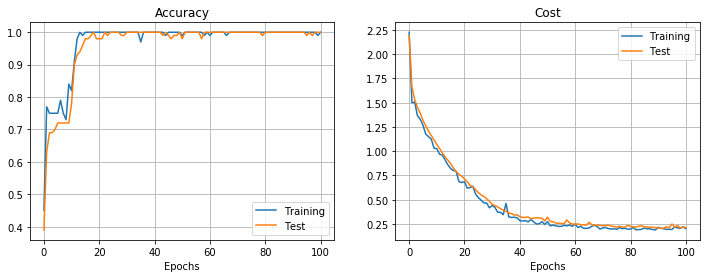

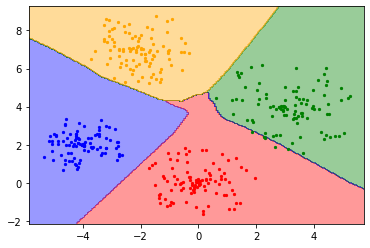

In [400]:
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data


N_train = 300
N_test = 100
N = N_train + N_test
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])
ids = np.random.choice(range(N), N, replace=False)
data = data[ids]
labels = labels[ids]


# 学習の設定
H_LAYERS = 5
H_UNITS = 10

# 勾配チェック
mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=2, eta=0.01, n_batch=50, l2=0.1,
                          debug_grad_check=True)
mlp.fit(data[:N_train], labels[:N_train], data[N_train:], labels[N_train:])
for err in mlp.grad_err:
    print(err)

# プロット
mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=100, eta=0.01, n_batch=32, l2=0.1)
mlp.fit(data[:N_train], labels[:N_train], data[N_train:], labels[N_train:])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.plot(range(len(mlp.acc_train)), mlp.acc_train, label='Training')
plt.plot(range(len(mlp.acc_test)), mlp.acc_test, label='Test')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.title('Cost')
plt.plot(range(len(mlp.cost_train)), mlp.cost_train, label='Training')
plt.plot(range(len(mlp.cost_test)), mlp.cost_test, label='Test')
plt.grid()
plt.legend()
plt.show()

plot(mlp, data, labels)
plt.show()

[2020/06/29 07:18:48] epoch 1 finished (acc=0.932, cost=0.5006819576134433)
[2020/06/29 07:18:58] epoch 2 finished (acc=0.958, cost=0.27848884479103697)
[2020/06/29 07:19:08] epoch 3 finished (acc=0.964, cost=0.23890052062193695)
[2020/06/29 07:19:18] epoch 4 finished (acc=0.971, cost=0.20656530641401263)
[2020/06/29 07:19:28] epoch 5 finished (acc=0.968, cost=0.1695002416814409)
[2020/06/29 07:19:38] epoch 6 finished (acc=0.973, cost=0.160335765658198)
[2020/06/29 07:19:48] epoch 7 finished (acc=0.97, cost=0.1654781460936951)
[2020/06/29 07:19:58] epoch 8 finished (acc=0.98, cost=0.1531344162042435)
[2020/06/29 07:20:08] epoch 9 finished (acc=0.978, cost=0.14269278347475114)
[2020/06/29 07:20:18] epoch 10 finished (acc=0.978, cost=0.1449994604006804)


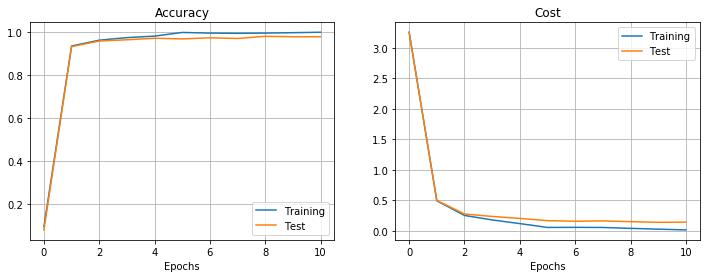

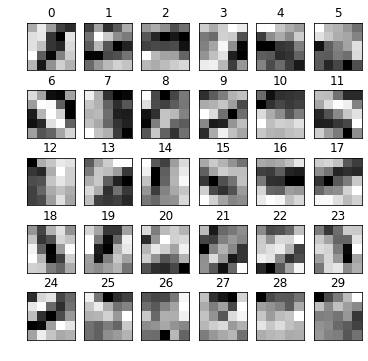

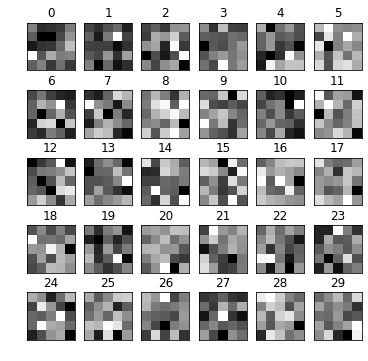

In [402]:
data = []
labels = []

def load_data(filename):
    data = []
    labels = []
    with open(filename) as f:
        lines = f.readlines()
        h, w = lines[0].split(',')
        h, w = int(h), int(w)
        for l in lines[1:]:
            arr = l.split(',')
            labels.append(arr[0])
            data.append([float(v) for v in arr[1:]])
        data = np.array(data).reshape(-1, 1, h, w)
        labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data('../data/mnist/mnist_train')
data_test, labels_test = load_data('../data/mnist/mnist_test')

# 時間がかかる場合はこちらの小さい方のデータを使う
N_train = 5000
N_test = 1000
ids = np.random.choice(range(len(data_train)), N_train, replace=False)
data_train_s, labels_train_s = data_train[ids], labels_train[ids]
ids = np.random.choice(range(len(data_test)), N_test, replace=False)
data_test_s, labels_test_s = data_test[ids], labels_test[ids]


# 勾配チェック
# MaxPooling を入れると性能が悪い。「ゼロから作る」を丸コピしてもダメ。
#cnn = CNNClassifier(FN=2, FH=3, FW=3, PH=2, PW=2, h_units=2, h_layers=1, conv_layers=1, epochs=1, eta=1e-1, n_batch=25, l2=1e-3,
#          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0, debug_grad_check=True)
#cnn.fit(data_train_s[:50], labels_train_s[:50], data_test_s[:10], labels_test_s[:10])


cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=10, eta=1e-1, n_batch=128, l2=1e-3,
                    stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
#cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.plot(range(len(cnn.acc_train)), cnn.acc_train, label='Training')
plt.plot(range(len(cnn.acc_test)), cnn.acc_test, label='Test')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.title('Cost')
plt.plot(range(len(cnn.cost_train)), cnn.cost_train, label='Training')
plt.plot(range(len(cnn.cost_test)), cnn.cost_test, label='Test')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()

cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=0, eta=1e-1, n_batch=128, l2=1e-3,
                    stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)
plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()

epoch 1 --- 2020/06/28 22:07:11
epoch 2 --- 2020/06/28 22:07:21
epoch 3 --- 2020/06/28 22:07:32
epoch 4 --- 2020/06/28 22:07:43
epoch 5 --- 2020/06/28 22:07:54
epoch 6 --- 2020/06/28 22:08:05
epoch 7 --- 2020/06/28 22:08:16
epoch 8 --- 2020/06/28 22:08:29
epoch 9 --- 2020/06/28 22:08:41
epoch 10 --- 2020/06/28 22:08:54
epoch 1 --- 2020/06/28 22:09:08
epoch 2 --- 2020/06/28 22:09:19
epoch 3 --- 2020/06/28 22:09:31
epoch 4 --- 2020/06/28 22:09:42
epoch 5 --- 2020/06/28 22:09:54
epoch 6 --- 2020/06/28 22:10:06
epoch 7 --- 2020/06/28 22:10:19
epoch 8 --- 2020/06/28 22:10:31
epoch 9 --- 2020/06/28 22:10:43
epoch 10 --- 2020/06/28 22:10:57
epoch 1 --- 2020/06/28 22:11:13
epoch 2 --- 2020/06/28 22:11:26
epoch 3 --- 2020/06/28 22:11:40
epoch 4 --- 2020/06/28 22:11:54
epoch 5 --- 2020/06/28 22:12:07
epoch 6 --- 2020/06/28 22:12:18
epoch 7 --- 2020/06/28 22:12:29
epoch 8 --- 2020/06/28 22:12:41
epoch 9 --- 2020/06/28 22:12:52
epoch 10 --- 2020/06/28 22:13:03
epoch 1 --- 2020/06/28 22:13:17
epoch

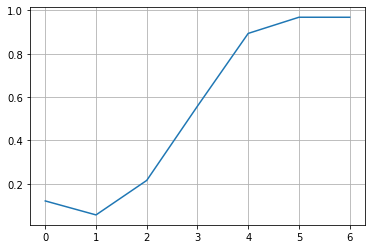

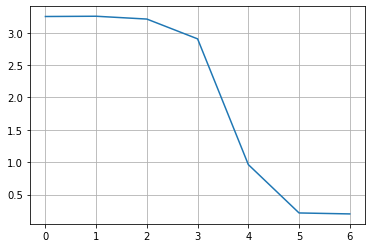

In [326]:
etas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
models = []
for eta in etas:
    cnn = CNNClassifier(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, conv_layers=1, epochs=10, eta=eta, n_batch=128, l2=1e-3,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
    #cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
    cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)
    models.append(cnn)
plt.plot(range(len(models)), [np.average(m.acc_test[-10:]) for m in models])
plt.grid()
plt.show()
plt.plot(range(len(models)), [np.average(m.cost_test[-10:]) for m in models])
plt.grid()
plt.show()

In [528]:
# 画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=128

def load_images(img_dir):
    images = []
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            images.append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    print('{} images are loaded'.format(len(images)))
    return images

img_dirs = {
    #'ladybug': '../data/image-net/images/ladybug',
    'spider': '../data/image-net/images/wolf_spider',
    #'garden_spider': '../data/image-net/images/garden_spider',
    'cockroach': '../data/image-net/images/cockroach'
}
images = {}

n_min = np.inf
for label, dir_path in img_dirs.items():
    images[label] = load_images(dir_path)
    if len(images[label]) < n_min:
        n_min = len(images[label])
data = []
labels = []
for k, v in images.items():
    data.extend(v[:n_min])
    labels.extend([k] * n_min)

data = np.array(data) / 255.0
labels = np.array(labels)

print('----------')
print('total {} images in data'.format(len(data)))

cannot identify image file '../data/image-net/images/wolf_spider/.DS_Store'
1160 images are loaded
cannot identify image file '../data/image-net/images/cockroach/.DS_Store'
773 images are loaded
----------
total 1546 images in data


In [529]:
import numpy as np
import pickle

N_train = 1000
N_test = 500

N = len(data)
ids = np.array(range(N))
np.random.shuffle(ids)

data_train, labels_train = data[ids[:N_train]], labels[ids[:N_train]]
data_test, labels_test = data[ids[N_train:N_train+N_test]], labels[ids[N_train:N_train+N_test]]

with open('../data/tmp/data_train.pkl', 'xb') as f:
    pickle.dump(data_train, f)
with open('../data/tmp/data_test.pkl', 'xb') as f:
    pickle.dump(data_test, f)
with open('../data/tmp/labels_train.pkl', 'xb') as f:
    pickle.dump(labels_train, f)
with open('../data/tmp/labels_test.pkl', 'xb') as f:
    pickle.dump(labels_test, f)

In [530]:
vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
                        dropout_ratio=0.3)

[2020/07/01 00:36:20] epoch 71 finished (acc=0.794, cost=0.865367941579698)
[2020/07/01 00:42:47] epoch 72 finished (acc=0.806, cost=0.8436503431605676)
[2020/07/01 00:49:16] epoch 73 finished (acc=0.82, cost=0.7871551739861177)
[2020/07/01 00:55:45] epoch 74 finished (acc=0.834, cost=0.761606891049601)
[2020/07/01 01:02:15] epoch 75 finished (acc=0.83, cost=0.7406976716821291)
[2020/07/01 01:08:48] epoch 76 finished (acc=0.818, cost=0.8078782575243213)
[2020/07/01 01:15:14] epoch 77 finished (acc=0.824, cost=0.8229901007128293)
[2020/07/01 01:21:44] epoch 78 finished (acc=0.808, cost=0.8532525504444738)
[2020/07/01 01:28:11] epoch 79 finished (acc=0.828, cost=0.7744277792263954)
[2020/07/01 01:34:45] epoch 80 finished (acc=0.798, cost=0.8570920357216638)


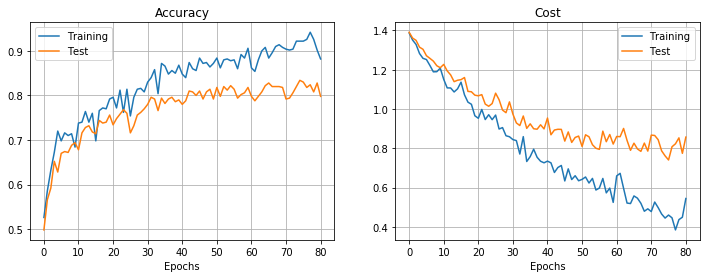

------------------------------------------------------------
All: 0.798 (399 / 500)
cockroach: 0.7738095238095238 (195 / 252)
spider: 0.8225806451612904 (204 / 248)
------------------------------------------------------------
[2020/07/01 01:42:43] epoch 81 finished (acc=0.826, cost=0.774211104106025)
[2020/07/01 01:49:12] epoch 82 finished (acc=0.812, cost=0.7768064656959008)
[2020/07/01 01:55:49] epoch 83 finished (acc=0.816, cost=0.7831973526586362)
[2020/07/01 02:02:19] epoch 84 finished (acc=0.824, cost=0.7811088463084255)
[2020/07/01 02:08:56] epoch 85 finished (acc=0.796, cost=0.8353622796758442)
[2020/07/01 02:15:28] epoch 86 finished (acc=0.812, cost=0.8080763770549015)
[2020/07/01 02:21:58] epoch 87 finished (acc=0.822, cost=0.8619025626830806)
[2020/07/01 02:28:35] epoch 88 finished (acc=0.802, cost=0.8528347034914237)
[2020/07/01 02:35:03] epoch 89 finished (acc=0.814, cost=0.7621048686140472)
[2020/07/01 02:41:36] epoch 90 finished (acc=0.832, cost=0.7700235705630932)


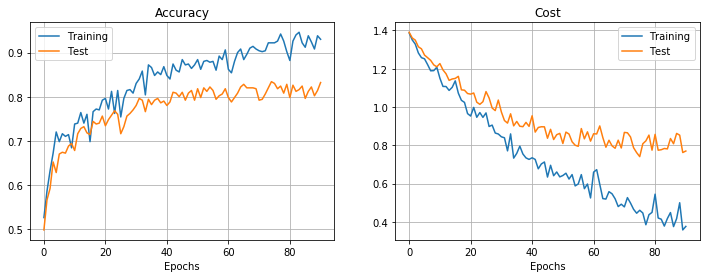

------------------------------------------------------------
All: 0.832 (416 / 500)
cockroach: 0.8095238095238095 (204 / 252)
spider: 0.8548387096774194 (212 / 248)
------------------------------------------------------------
[2020/07/01 02:49:40] epoch 91 finished (acc=0.814, cost=0.8321784166493659)
[2020/07/01 02:56:31] epoch 92 finished (acc=0.828, cost=0.7830563437036835)
[2020/07/01 03:03:06] epoch 93 finished (acc=0.812, cost=0.8717649273903497)
[2020/07/01 03:09:39] epoch 94 finished (acc=0.828, cost=0.8319648968922542)
[2020/07/01 03:16:20] epoch 95 finished (acc=0.822, cost=0.8276204169258934)
[2020/07/01 03:22:51] epoch 96 finished (acc=0.816, cost=0.8439957326982176)
[2020/07/01 03:29:20] epoch 97 finished (acc=0.804, cost=0.8870823843354435)
[2020/07/01 03:35:50] epoch 98 finished (acc=0.818, cost=0.802074868526282)
[2020/07/01 03:42:30] epoch 99 finished (acc=0.834, cost=0.759595072688219)
[2020/07/01 03:49:15] epoch 100 finished (acc=0.804, cost=0.8265875564374053)


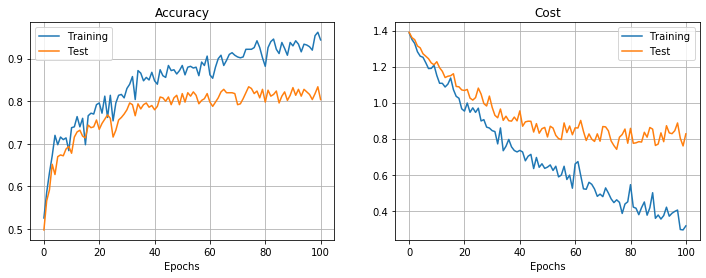

------------------------------------------------------------
All: 0.804 (402 / 500)
cockroach: 0.7976190476190477 (201 / 252)
spider: 0.8104838709677419 (201 / 248)
------------------------------------------------------------


In [535]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

#途中から再開する時
#with open('../data/tmp/vgg.pkl', 'rb') as f:
#    vgg = pickle.load(f)

for i in range(5):
    vgg.fit(data_train, labels_train, data_test, labels_test)
    
    try:
        with open('../data/tmp/vgg.pkl'.format(len(vgg.cost_train)), 'wb') as f:
            pickle.dump(vgg, f)
    except OverflowError as err:
        print(err)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.plot(range(len(vgg.acc_train)), vgg.acc_train, label='Training')
    plt.plot(range(len(vgg.acc_test)), vgg.acc_test, label='Test')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.title('Cost')
    plt.plot(range(len(vgg.cost_train)), vgg.cost_train, label='Training')
    plt.plot(range(len(vgg.cost_test)), vgg.cost_test, label='Test')
    plt.grid()
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(6, 6))
    for i in range(cnn.FN):
        plt.subplot(cnn.FN//6, 6, i+1)
        plt.title(i)
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
    plt.show()
    """

    print('------------------------------------------------------------')
    labels_pred = predict(data_test)
    accuracy_array = labels_test == labels_pred
    n_total = len(accuracy_array)
    n_ok = np.count_nonzero(accuracy_array)
    print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
    for l in np.unique(labels_test):
        ids = np.where(labels_test == l)[0]
        n_total = len(ids)
        n_ok = np.count_nonzero(accuracy_array[ids])
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    print('------------------------------------------------------------')

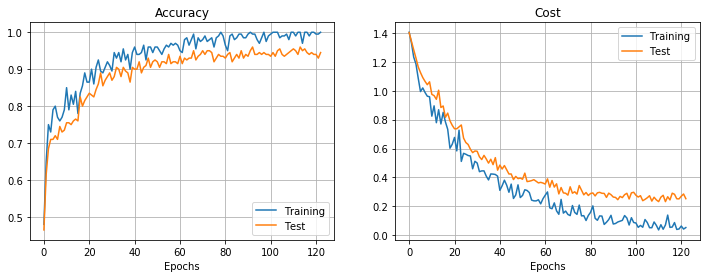

All: spider (0.945 / 189)
ladybug: 0.9230769230769231 (96 / 104)
spider: 0.9789473684210527 (93 / 95)


In [476]:
# ベースライン
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

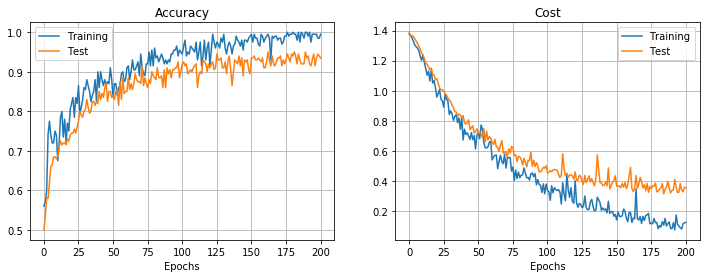

All: 0.935 (187 / 200)
ladybug: 0.8942307692307693 (93 / 104)
spider: 0.9791666666666666 (94 / 96)


In [492]:
# Dropout 0.3 -> 0.5：収束までの時間は増加、最終的な性能は変わらず
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.5)

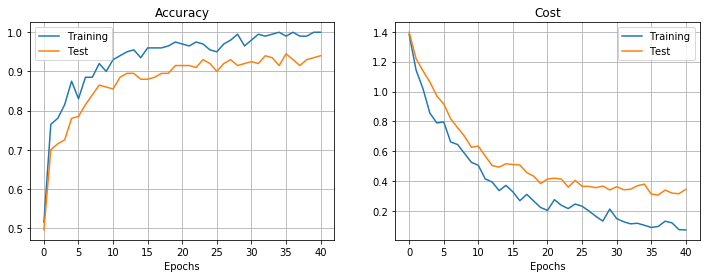

All: 0.93 (186 / 200)
ladybug: 0.8846153846153846 (92 / 104)
spider: 0.9791666666666666 (94 / 96)


In [495]:
# Dropout 0.3 -> 0：高速で収束、性能あまり変わらず。Dropout 不要？
# ladybug vs spider, 64x64, (N_train, N_test) = (1000, 200)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0)

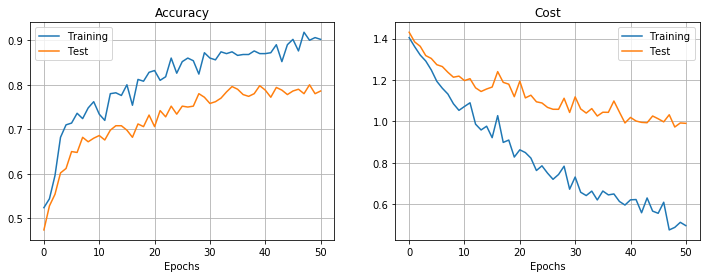

All: 0.786 (393 / 500)
cockroach: 0.7953667953667953 (206 / 259)
spider: 0.7759336099585062 (187 / 241)


In [527]:
# 比較対象を変更：比較的性能が低い
# spider vs cockroach, 64x64, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

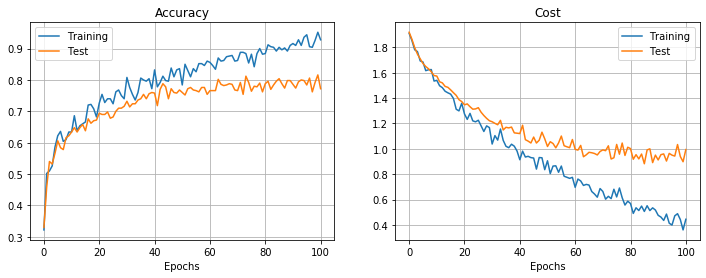

All: 0.772 (386 / 500)
cockroach: 0.7987012987012987 (123 / 154)
ladybug: 0.8421052631578947 (144 / 171)
spider: 0.68 (119 / 175)


In [522]:
# 3値分類へ変更：2値分類に比べて性能が出ない
# ladybug vs spider vs cockroach, 64x64, (N_train, N_test) = (1500, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)

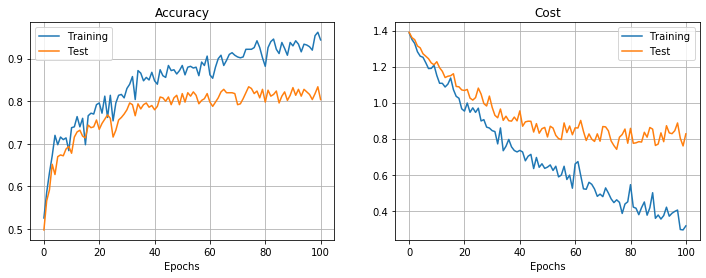

All: 0.804 (402 / 500)
cockroach: 0.7976190476190477 (201 / 252)
spider: 0.8104838709677419 (201 / 248)


In [536]:
# 128x128 画像に変更して、spider vs cockroach の2値分類リベンジ：あまり変わらない -> 解像度はそれほど問題ではない？
# spider vs cockroach, 128x128, (N_train, N_test) = (1000, 500)
# vgg = VGGLikeClassifier(FN=16, h_units=1024, h_layers=1, conv_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                         dropout_ratio=0.3)
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.plot(range(len(vgg.acc_train)), vgg.acc_train, label='Training')
    plt.plot(range(len(vgg.acc_test)), vgg.acc_test, label='Test')
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.title('Cost')
    plt.plot(range(len(vgg.cost_train)), vgg.cost_train, label='Training')
    plt.plot(range(len(vgg.cost_test)), vgg.cost_test, label='Test')
    plt.grid()
    plt.legend()
    plt.show()

    labels_pred = predict(data_test)
    accuracy_array = labels_test == labels_pred
    n_total = len(accuracy_array)
    n_ok = np.count_nonzero(accuracy_array)
    print('All: {} ({} / {})'.format(n_ok/n_total, n_ok, n_total))
    for l in np.unique(labels_test):
        ids = np.where(labels_test == l)[0]
        n_total = len(ids)
        n_ok = np.count_nonzero(accuracy_array[ids])
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

In [ ]:
# 犬猫画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=128

def load_cats_and_dogs_images(img_dir):
    images_ = {'cat': [], 'dog': []}
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            l = 'cat' if img_file[0].isupper() else 'dog'
            images_[l].append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    for k, v in images_.items():
        print('{} {} images are loaded'.format(len(v), k))
    return images_

images = load_cats_and_dogs_images('../data/Oxford-IIIT-Pet-Dataset/images')